In [42]:
import numpy as np

In [48]:
def matrix_KKT(G, A, C, z, n, m, p, N):
    KKT = np.zeros((N, N))
    KKT[0:n, 0:n] = G
    KKT[n:n + p, 0:n] = -A.T
    KKT[0:n, n:n + p] = -A
    KKT[n + p:n + p + m, 0:n] = -C.T
    KKT[0:n, n + p:n + p + m] = -C
    KKT[-2 * m:-m, -m:] = np.eye(m)
    KKT[-m:, -2 * m:-m] = np.diag(z[-m:])
    KKT[-m:, -m:] = np.diag(z[-2 * m:-m])
    return KKT


def F(z, G, A, C, g, b, d, n, m, p, N):
    x = z[:n]
    gmm = z[n:n + p]
    lbd = z[-2 * m:-m]
    s = z[-m:]
    F = np.zeros(N)
    F[:n] = np.matmul(G, x) + g - np.matmul(A, gmm) - np.matmul(C, lbd)
    F[n:n + p] = b - np.matmul(A.T, x)
    F[-2 * m:-m] = s + d - np.matmul(C.T, x)
    F[-m:] = s * lbd
    return F


def Newton_step(lamb0, dlamb, s0, ds):
    alp = 1
    idx_lamb0 = np.array(np.where(dlamb < 0))
    if idx_lamb0.size > 0:
        alp = min(alp, np.min(-lamb0[idx_lamb0] / dlamb[idx_lamb0]))
    idx_s0 = np.array(np.where(ds < 0))
    if idx_s0.size > 0:
        alp = min(alp, np.min(-s0[idx_s0] / ds[idx_s0]))
    return alp


def algorithm(z, ln_sys, KKT, rhv, G, A, C, g, b, d, n, m, p, N):
    epsilon = 1e-16
    lbd = z[-2 * m:-m]
    s = z[-m:]
    #predictor substep
    d_z = np.linalg.solve(KKT, rhv)
    #step-size correction substep
    d_lbd = d_z[-2 * m:-m]
    d_s = d_z[-m:]
    alpha = Newton_step(lbd, d_lbd, s, d_s)
    #3things
    mu = np.matmul(s, lbd) / m
    mu_tilda = np.matmul(s + alpha * d_s, lbd + alpha * d_lbd) / m
    sigma = (mu_tilda / mu)**3
    #corrector substep
    rhv[-m:] = rhv[-m:] - d_s * d_lbd + sigma * mu
    d_z = np.linalg.solve(KKT, rhv)
    #step-size correction substep
    d_lbd = d_z[-2 * m:-m]
    d_s = d_z[-m:]
    alpha = Newton_step(lbd, d_lbd, s, d_s)
    #update substep
    z = z + 0.95 * alpha * d_z
    KKT = matrix_KKT(G, A, C, z, n, m, p, N)
    rhv = -F(z, G, A, C, g, b, d, n, m, p, N)
    norm_rL = np.linalg.norm(rhv[:n])
    norm_rC = np.linalg.norm(rhv[n:n + p])
    if norm_rL < epsilon:
        print('norm_rL')
        return False, z, KKT, rhv
    if norm_rC < epsilon and rhv[n:n + p].size > 0:
        print('rC:{} shape:{} norm_rC:{}'.format(rhv[n:n + p],
                                                 rhv[n:n + p].shape, norm_rC))
        return False, z, KKT, rhv
    if abs(mu) < epsilon:
        print('mu')
        return False, z, KKT, rhv
    return True, z, KKT, rhv

# 2 solving the KKT system

## 2.1 Inequality constrains case (i.e. with A = 0)

### C2

In [49]:
import numpy as np


def c2(n):
    m = 2 * n
    p = 0
    N = n + p + 2 * m
    A = np.zeros((n, p))
    G = np.eye(n)
    C = np.zeros((n, m))
    C[:, :n] = np.eye(n)
    C[:, n:] = -np.eye(n)
    b = np.zeros(p)
    d = np.array([-10] * m)
    g = np.random.rand(n)
    z = np.zeros(N)
    z[-2 * m:] = 1
    KKT = matrix_KKT(G, A, C, z, n, m, p, N)
    niter = 100
    loop = True
    rhv = -F(z, G, A, C, g, b, d, n, m, p, N)
    iloop = 0
    while loop and iloop < niter:
        #print('iloop:{} loop:{} z-g:{}'.format(iloop,loop,z[:n]-g))
        loop, z, KKT, rhv = algorithm(z, np.linalg.solve, KKT, rhv, G, A, C, g,
                                      b, d, n, m, p, N)
        iloop = iloop + 1
    print('z:{} g:{}'.format(z[:n], -g))
    return


c2(3)

norm_rL
z:[-0.03790929 -0.09382124 -0.28924382] g:[-0.03790929 -0.09382124 -0.28924382]


## c3

In [45]:
import time


def c3():
    n_list = []
    t_list = []
    for n in range(2, 100):
        n_list.append(n)
        t0 = time.clock()
        c2(n)
        t_list.append(time.clock() - t0)
    return n_list, t_list


n_list, t_list = c3()

/home/alfons/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/home/alfons/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.


norm_rL
z:[-0.61443814 -0.29304623] g:[-0.61443814 -0.29304623]
norm_rL
z:[-0.616723   -0.03372112 -0.79378277] g:[-0.616723   -0.03372112 -0.79378277]
norm_rL
z:[-0.53681113 -0.64750667 -0.92810194 -0.56483095] g:[-0.53681113 -0.64750667 -0.92810194 -0.56483095]
norm_rL
z:[-0.55504781 -0.09081849 -0.04543084 -0.97539585 -0.06838924] g:[-0.55504781 -0.09081849 -0.04543084 -0.97539585 -0.06838924]
norm_rL
z:[-0.05893153 -0.64165036 -0.51276357 -0.93995026 -0.73797565 -0.22079157] g:[-0.05893153 -0.64165036 -0.51276357 -0.93995026 -0.73797565 -0.22079157]
norm_rL
z:[-0.52973516 -0.86083944 -0.89236449 -0.00307489 -0.45170447 -0.0620384
 -0.54470805] g:[-0.52973516 -0.86083944 -0.89236449 -0.00307489 -0.45170447 -0.0620384
 -0.54470805]
norm_rL
z:[-0.84935708 -0.42384316 -0.69491838 -0.11145885 -0.86658697 -0.06809793
 -0.42356152 -0.57255436] g:[-0.84935708 -0.42384316 -0.69491838 -0.11145885 -0.86658697 -0.06809793
 -0.42356152 -0.57255436]
norm_rL
z:[-0.26202656 -0.20006557 -0.29233249

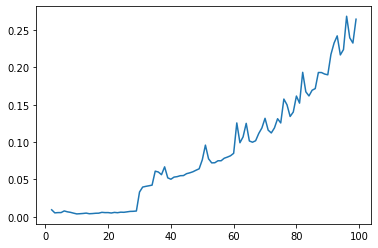

In [47]:
import matplotlib.pyplot as plt

plt.plot(n_list, t_list)

## c4

In [245]:
B = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
B[3:3]

array([], dtype=int64)

In [219]:
#p=0
def f(n):
    def g():
        global n, p
        print('G  n:{} p:{}'.format(n, p))
        return

    p = 0
    print('F  n:{} p:{}'.format(n, p))
    g()
    return

In [220]:
global A
A = np.zeros((2, 2))
f(4)

F  n:4 p:0
G  n:4 p:0


In [275]:
A = np.array([1, 2, 3])
B = np.array([4, 5, 6])
C = np.array([[1], [2], [3]])
A * B, (np.diag(A).dot(np.diag(B))).dot(np.array([1] * 3))

(array([ 4, 10, 18]), array([ 4, 10, 18]))

In [222]:
A - B - 1

array([-1, -1, -1])

In [223]:
np.matmul(np.diag(A), np.diag(A)).dot(np.array([1, 1, 1]))

array([1, 4, 9])

In [224]:
A * B

array([1, 4, 9])

In [225]:
a = 1
b = 2
c = 3

In [226]:
if a == 100 or b < 1 or c > 1:
    print('it works')

it works


In [227]:
abs(-2)

2

In [228]:
np.array([1] * 3)

array([1, 1, 1])

In [229]:
np.diag(np.random.rand(5))

array([[0.25559587, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.78634265, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.99005765, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.04302561, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.03541028]])

In [230]:
np.diag(np.array([-10] * 3))

array([[-10,   0,   0],
       [  0, -10,   0],
       [  0,   0, -10]])